In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, \
make_scorer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from importlib import reload
from src.functions import load_OU_data, CourseScaler
import warnings

warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
pd.set_option('display.max_columns',None)


## Drop the irrelevant columns, 

In [2]:

df = load_OU_data()
#df = pd.read_csv('../content/cleaned_registrations.csv')
df.drop(columns = ['id_student','code_presentation'], 
        inplace = True)

## Preprocessing

In [3]:
X = df.drop(columns = ['final_result'])
y = df['final_result']
print(y.value_counts())
encoder = LabelEncoder()
enc_y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,enc_y, random_state=111, test_size=0.2)


Pass           11793
Fail            5575
Distinction     2820
Withdrawn       2028
Name: final_result, dtype: int64


In [4]:
cs = CourseScaler()
X_Train_sc = cs.fit_transform(X_train)
X_test_sc = cs.transform(X_test)
test = cs.fit(X_train)

In [5]:
X_train

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,module_presentation_length,days_studied,activities_completed,total_clicks,assessments_completed,average_score
0,1,F,South East Region,A Level or Equivalent,20-30%,0-35,0,75,N,-31.0,234,15,64,133,4,83.750000
1,2,F,East Anglian Region,A Level or Equivalent,80-90%,0-35,0,60,N,-93.0,241,67,456,1798,2,84.500000
2,3,F,Ireland,A Level or Equivalent,30-40%,0-35,1,90,N,-137.0,261,97,423,1055,3,73.333333
3,5,M,Wales,Lower Than A Level,30-40%,0-35,0,120,N,-24.0,269,133,1127,4582,6,97.500000
4,2,M,Wales,A Level or Equivalent,20-30%,0-35,0,60,N,-49.0,269,34,111,245,4,81.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17767,2,M,West Midlands Region,Lower Than A Level,10-20,0-35,0,60,N,-64.0,269,88,681,2909,2,70.500000
17768,1,F,East Anglian Region,A Level or Equivalent,80-90%,0-35,0,60,N,-73.0,234,32,124,296,7,88.142857
17769,1,F,East Anglian Region,A Level or Equivalent,80-90%,0-35,0,120,N,-160.0,262,27,116,202,2,79.000000
17770,3,M,East Anglian Region,A Level or Equivalent,90-100%,0-35,0,120,N,-121.0,261,37,178,464,3,81.333333


In [6]:
X_test_sc

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,module_presentation_length,days_studied,activities_completed,total_clicks,assessments_completed,average_score
1985,F,East Midlands Region,A Level or Equivalent,10-20,35-55,-0.365381,-0.586170,N,1.004660,1.053893,-0.587349,-0.507412,-0.443752,0.455728,-0.345589
3560,F,South Region,HE Qualification,80-90%,0-35,-0.365381,0.270092,N,-1.329976,-1.371387,0.248124,-0.016760,0.262867,1.727788,0.140090
21265,F,South West Region,Lower Than A Level,40-50%,35-55,-0.179597,-0.253393,N,-0.565393,-1.365870,-0.473979,-0.234075,-0.127145,-0.070302,0.646389
12607,M,South Region,A Level or Equivalent,40-50%,0-35,-0.422225,-0.626092,N,0.728049,0.872768,-0.599137,-0.764180,-0.618356,-0.046945,0.488676
7788,M,South Region,A Level or Equivalent,90-100%,0-35,4.425848,-0.294008,N,0.262768,0.841902,-0.407580,-0.435412,-0.435393,-0.195895,-1.693218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,F,South Region,A Level or Equivalent,40-50%,0-35,-0.365381,-0.586170,N,-1.285507,-0.943396,3.214054,4.053570,6.299912,1.091758,1.032576
1295,F,Wales,Lower Than A Level,20-30%,0-35,-0.365381,-0.586170,N,0.315386,-0.943396,-0.127839,0.232020,-0.168063,-0.180302,-0.482575
13895,M,Yorkshire Region,Lower Than A Level,40-50%,35-55,-0.216277,-1.147047,N,0.778182,-1.798743,-1.459854,-1.095206,-0.914255,-2.166359,-4.753721
12884,M,East Anglian Region,Lower Than A Level,70-80%,0-35,-0.216277,-0.094754,N,-0.336474,0.509597,1.478014,0.550627,0.220696,-0.207307,0.482649


In [7]:
X_Train_sc

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,module_presentation_length,days_studied,activities_completed,total_clicks,assessments_completed,average_score
3625,F,South East Region,A Level or Equivalent,20-30%,0-35,-0.365381,-0.158039,N,0.737844,-1.371387,-0.712670,-0.728550,-0.566875,-0.180302,0.622655
6243,F,East Anglian Region,A Level or Equivalent,80-90%,0-35,-0.225832,-0.294008,N,-0.406473,-1.187193,0.991371,1.150206,0.950728,-1.176844,0.514698
10014,F,Ireland,A Level or Equivalent,30-40%,0-35,1.328051,0.263307,N,-1.343181,0.775862,1.603367,0.654156,0.487505,-0.582438,0.063255
19841,M,Wales,Lower Than A Level,30-40%,0-35,-0.375222,0.896378,N,0.943459,0.883639,2.574506,2.637253,2.123944,0.889184,1.660055
7444,M,Wales,A Level or Equivalent,20-30%,0-35,-0.225832,-0.294008,N,0.389381,0.841902,-0.291001,-0.608760,-0.659329,0.785054,0.342333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7443,M,West Midlands Region,Lower Than A Level,10-20,0-35,-0.225832,-0.294008,N,0.118067,0.841902,1.807425,2.297358,2.102547,-1.176844,-0.174763
4182,F,East Anglian Region,A Level or Equivalent,80-90%,0-35,-0.365381,-0.586170,N,-0.196010,-1.371387,-0.002518,-0.313915,-0.348733,1.727788,0.896183
4820,F,East Anglian Region,A Level or Equivalent,80-90%,0-35,-0.365381,1.126354,N,-2.130423,0.625903,-0.211386,-0.369200,-0.474533,-1.452363,0.326889
10196,M,East Anglian Region,A Level or Equivalent,90-100%,0-35,-0.422225,1.152705,N,-1.011785,0.775862,-0.461480,-0.508025,-0.386243,-0.582438,0.555309


In [8]:
categoricals = X.select_dtypes(include = 'object').columns
numericals = X.select_dtypes(include = 'number').columns

transformers = [('scaler', CourseScaler(), numericals),
                ('ohe', OneHotEncoder(sparse = False, drop= 'first'), categoricals)]

col_transformer = ColumnTransformer(transformers = transformers)

cv = KFold(n_splits = 5, shuffle = True, random_state = 111)

In [9]:
col_transformer.fit_transform(X_train)

array([[-0.36538129, -0.15803882,  0.73784398, ...,  0.        ,
         0.        ,  0.        ],
       [-0.22583232, -0.29400799, -0.40647287, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.32805128,  0.2633065 , -1.3431813 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.36538129,  1.126354  , -2.1304229 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.42222507,  1.15270531, -1.01178452, ...,  0.        ,
         0.        ,  0.        ],
       [-0.42222507, -0.62609231,  1.01802075, ...,  0.        ,
         0.        ,  0.        ]])

# FSM

Classification Report
accuracy 0.6064356435643564
              precision    recall  f1-score   support

 Distinction       0.62      0.21      0.31       576
        Fail       0.58      0.46      0.51      1133
        Pass       0.61      0.88      0.72      2328
   Withdrawn       0.50      0.00      0.00       407

    accuracy                           0.61      4444
   macro avg       0.58      0.39      0.39      4444
weighted avg       0.59      0.61      0.55      4444



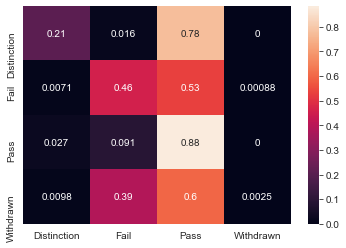

In [12]:
LRpipeline = Pipeline(steps = [('processor', col_transformer),
                             ('model', LogisticRegression())])

LRpipeline.fit(X_train, y_train)
y_pred = LRpipeline.predict(X_test)

labeled_y_test = encoder.inverse_transform(y_test)
y_pred = encoder.inverse_transform(y_pred)

print('Classification Report')
print('accuracy',accuracy_score(labeled_y_test,y_pred))
print(classification_report(labeled_y_test, y_pred))
sns.heatmap(confusion_matrix(labeled_y_test,y_pred, normalize = 'true'),
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_,
   annot = True)

# FSM Evaluation

# Summary
This FSM predicted that most students would pass.  It almost entirely lumped together those passing with distinction and those just passing.  It also predicted most failing students to pass as well.  It did not predict any students would withdraw.  This is disappointing because preventing withdrawals is my first priority.

### Next Steps:
It may be worth it, given my business goals, to combine the 'Distinction' and 'Pass classes', especially since this model doesn't seem to differentiate those anyway.  Another thing to try would be to combine the 'Fail' and 'Withdrawn' classes, though I think there is an important distinction between those classes and they may need different kinds of intervention.  It would divide 'needs intervention' and 'does not need intervention', however.

Another idea would be to address the class imbalance by weighting the classes in the regressor, SMOTING, or over/under sampling.

I am also only using the first 90 days of the course, which is only about 1/3 of the total course length.  I could increase my data by increaseing that to 120 days.

Finally, I have several highly correlated variable currently, including days studied, percent of days studed, and clicks per day.  I could choose one of those to include and not the others.  I could also change clicks per day to avg clicks per activity or total clicks to reduce the correlation



In [ ]:
len(X)

In [ ]:
y.value_counts()